In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = "Stock_Data/Stocks"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1a-I9epOaGdMqEQjvMO-SGs4iDefnoraJ/Stocks


# Imports

In [ ]:
import numpy as np
import datetime
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


import plotly.graph_objects as go

import xgboost as xgb

import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LayerNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Custom LSTM Model



In [ ]:
"""LSTM Model"""

class PriceClassifier():

  stock: str
  stock_history_df: pd.DataFrame
  model: Sequential

  def __init__(self, stock: str):
    self.stock = stock
    self.stock_history_df = self._get_stock_history_df()
    self.train_data, self.test_data, self.val_data = self._create_train_and_test_set()
    self.X_train, self.y_train, self.X_val, self.y_val, self.X_test, self.y_test = self._preprocess()
    self.predictions = None

  def _get_stock_history_df(self):
    stock_country = "us"
    stock_history_path = f"{self.stock}.{stock_country}.txt"
    return pd.read_csv(stock_history_path)

  def plot_daily_close(self):
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Date', y='Close', data=self.stock_history_df)
    plt.xlabel('Date')
    plt.ylabel('Close price')
    plt.title('AMTD daily close price 2010-2017')
    plt.show()

  def _create_train_and_test_set(self, chunk_size=10):

    # dataset = self.stock_history_df

    # dataset["Date"] = pd.to_datetime(dataset["Date"]).dt.date

    # test_start = datetime.date.fromisoformat('2014-04-30')
    # test_end = datetime.date.fromisoformat('2015-04-30')

    # train_data = dataset.loc[dataset['Date'] < test_start]
    # test_data = dataset.loc[(dataset['Date'] >= test_start) & (dataset['Date'] <= test_end)]
    # validation_data = dataset.loc[dataset['Date'] > test_end]
    # print(len(validation_data))

    # return train_data, test_data, validation_data

    train_size = 0.8
    test_size = 0.1
    validation_size = 0.1
    dataset = self.stock_history_df
    #dataset["Date"] = pd.to_datetime(dataset["Date"]).dt.date

    start_date = datetime.date(2005, 3, 1)
    dataset = dataset[pd.to_datetime(dataset["Date"]).dt.date > start_date]

    train_end = int(len(dataset) * train_size)
    test_end = train_end + int(len(dataset) * test_size)

    train_data = dataset.iloc[:train_end]
    test_data = dataset.iloc[train_end:test_end]
    validation_data = dataset.iloc[test_end:]
    return train_data, test_data, validation_data

  def plot_train_test_val(self):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=self.train_data['Date'], y=self.train_data['Close'], mode='lines', name='Train data'))
    fig.add_trace(go.Scatter(x=self.test_data['Date'], y=self.test_data['Close'], mode='lines', name='Test data'))
    fig.add_trace(go.Scatter(x=self.val_data['Date'], y=self.val_data['Close'], mode='lines', name='Validation data'))


    fig.update_layout(
        title=f'{self.stock.upper()} daily close price 2010-2017',
        xaxis_title='Date',
        yaxis_title='Close price',
    )

    fig.show()

  def _preprocess(self):
    X_train = self.train_data.drop(columns=['Close', 'Date'])
    y_train = self.train_data['Close']
    X_validation = self.val_data.drop(columns=['Close', 'Date'])
    y_validation = self.val_data['Close']
    X_test = self.test_data.drop(columns=['Close', 'Date'])
    y_test = self.test_data['Close']

    return X_train, y_train, X_validation, y_validation, X_test, y_test

  def train(self, model=None, optimizer=None, learning_rate = .001, epochs=50, batch_size=32, loss="mean_squared_error", dropout=.2, layer_norm=False):
    if not model:
      model = Sequential()
      model.add(LSTM(units=50,return_sequences=True,input_shape=(self.X_train.shape[1], 1)))
      model.add(Dropout(dropout))
      if layer_norm:
        model.add(LayerNormalization())
      model.add(LSTM(units=50,return_sequences=True))
      model.add(Dropout(dropout))
      if layer_norm:
        model.add(LayerNormalization())
      model.add(LSTM(units=50,return_sequences=True))
      model.add(Dropout(dropout))
      if layer_norm:
        model.add(LayerNormalization())
      model.add(LSTM(units=50))
      model.add(Dropout(dropout))
      if layer_norm:
        model.add(LayerNormalization())
      model.add(Dense(units=1))

    if not optimizer:
      optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,loss=loss)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(self.X_train,self.y_train,epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(self.X_val, self.y_val),
                        callbacks=[early_stopping])
    self.model = model

  def generate_predictions(self):
    self.predictions= self.model.predict(self.X_test)

    print(self.test_data)

  def get_true_price_on_date(self, date):

    # return self.test_data.loc[self.test_data['Date'] == date][["Open", "High", "Low", "Volume", "OpenInt"]]

    return self.stock_history_df.loc[self.stock_history_df['Date'] == date][["Open", "High", "Low", "Volume", "OpenInt"]]

  def predict_on_date(self, date):

    true_price = self.get_true_price_on_date(date)

    if true_price.empty:
      return None

    predicted_price = self.model.predict(true_price)

    return predicted_price

  def get_predictions(self):

    return self.predictions

  def get_stock_name(self):

    return self.stock

  def plot_predictions(self):

    if self.predictions is not None:
      plt.figure(figsize=(10, 6))
      plt.plot(self.test_data['Date'], self.test_data['Close'], label='Actual')
      plt.plot(self.test_data['Date'], self.predictions, label='Predicted')
      plt.xlabel('Date')
      plt.ylabel('Close Price')
      plt.title(f'Actual vs. Test {self.stock.upper()} daily close prices')
      plt.legend()
      plt.xticks([])
      plt.tight_layout()
      plt.show()

  def get_prediction_error(self):

    if self.predictions is not None:
      mse = tf.keras.losses.MeanSquaredError()
      return mse(self.y_test, self.predictions).numpy()

  def eval(self):
    self.model.evaluate(self.X_test, self.y_test)



Epoch 1/50
80/80 [==============================] - 12s 46ms/step - loss: 158.5162 - val_loss: 780.9714
Epoch 2/50
80/80 [==============================] - 2s 27ms/step - loss: 51.4334 - val_loss: 634.5031
Epoch 3/50
80/80 [==============================] - 2s 27ms/step - loss: 41.5495 - val_loss: 569.3174
Epoch 4/50
80/80 [==============================] - 2s 27ms/step - loss: 39.2328 - val_loss: 549.2107
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 39.3413 - val_loss: 540.9317
Epoch 6/50
80/80 [==============================] - 1s 17ms/step - loss: 39.5515 - val_loss: 539.1230
Epoch 7/50
80/80 [==============================] - 1s 17ms/step - loss: 39.1782 - val_loss: 539.8677
Epoch 8/50
80/80 [==============================] - 1s 17ms/step - loss: 39.1624 - val_loss: 534.6583
Epoch 9/50
80/80 [==============================] - 1s 17ms/step - loss: 38.9034 - val_loss: 537.6384
Epoch 10/50
80/80 [==============================] - 1s 17ms/step - loss: 39.271

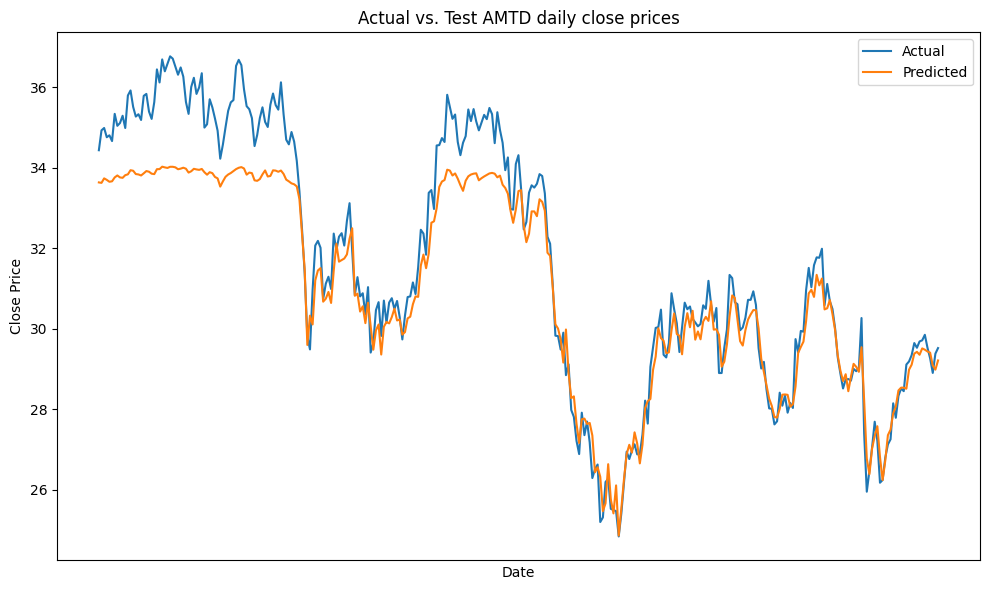

In [ ]:
amtd_model = PriceClassifier("amtd")
amtd_model.train()
amtd_model.generate_predictions()
amtd_model.plot_predictions()
amtd_model.plot_train_test_val()

Epoch 1/50
80/80 [==============================] - 14s 47ms/step - loss: 104.6145 - val_loss: 704.5383
Epoch 2/50
80/80 [==============================] - 2s 20ms/step - loss: 48.4532 - val_loss: 520.4653
Epoch 3/50
80/80 [==============================] - 2s 20ms/step - loss: 38.8313 - val_loss: 462.0505
Epoch 4/50
80/80 [==============================] - 2s 25ms/step - loss: 34.7463 - val_loss: 406.9341
Epoch 5/50
80/80 [==============================] - 3s 33ms/step - loss: 18.1442 - val_loss: 258.9676
Epoch 6/50
80/80 [==============================] - 3s 32ms/step - loss: 8.8368 - val_loss: 169.7751
Epoch 7/50
80/80 [==============================] - 2s 28ms/step - loss: 4.7558 - val_loss: 120.7237
Epoch 8/50
80/80 [==============================] - 2s 25ms/step - loss: 3.0050 - val_loss: 94.2604
Epoch 9/50
80/80 [==============================] - 2s 22ms/step - loss: 2.2259 - val_loss: 79.6123
Epoch 10/50
80/80 [==============================] - 2s 21ms/step - loss: 1.9277 - val

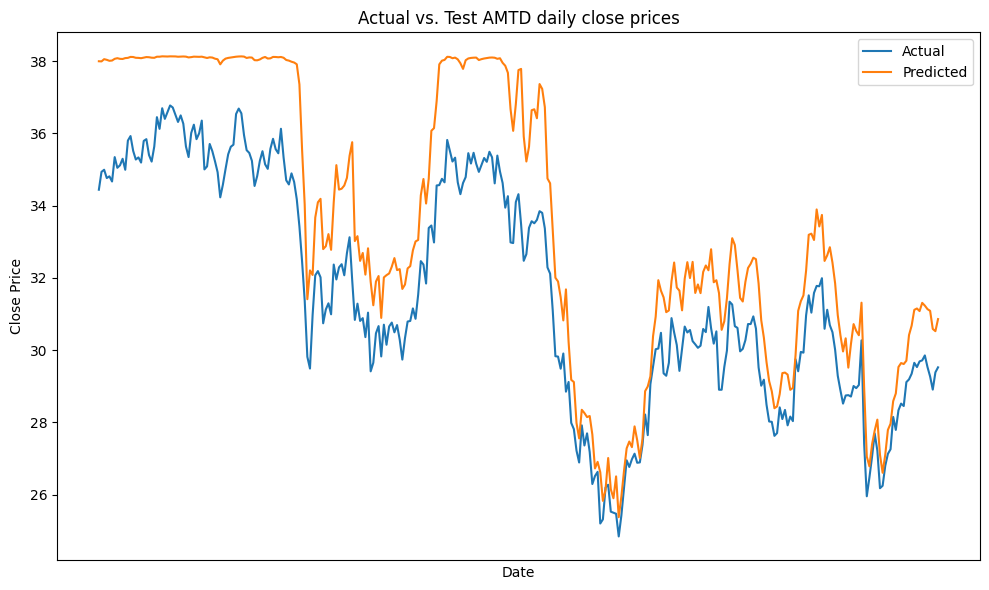

In [ ]:
amtd_batch_norm = PriceClassifier("amtd")
amtd_batch_norm.train(layer_norm=True)
amtd_batch_norm.generate_predictions()
amtd_batch_norm.plot_predictions()
amtd_batch_norm.plot_train_test_val()

Epoch 1/50
80/80 [==============================] - 11s 37ms/step - loss: 10.1284 - val_loss: 27.3633
Epoch 2/50
80/80 [==============================] - 2s 23ms/step - loss: 4.5336 - val_loss: 24.6733
Epoch 3/50
80/80 [==============================] - 2s 27ms/step - loss: 4.2229 - val_loss: 24.2722
Epoch 4/50
80/80 [==============================] - 2s 27ms/step - loss: 4.2471 - val_loss: 24.4418
Epoch 5/50
80/80 [==============================] - 2s 26ms/step - loss: 4.1952 - val_loss: 24.4116
Epoch 6/50
80/80 [==============================] - 1s 17ms/step - loss: 4.2056 - val_loss: 24.3114
Epoch 7/50
80/80 [==============================] - 1s 17ms/step - loss: 4.1833 - val_loss: 24.3270
Epoch 8/50
80/80 [==============================] - 1s 17ms/step - loss: 4.2317 - val_loss: 24.3392
Epoch 9/50
80/80 [==============================] - 1s 17ms/step - loss: 4.2098 - val_loss: 24.4002
Epoch 10/50
80/80 [==============================] - 1s 17ms/step - loss: 4.1964 - val_loss: 24.33

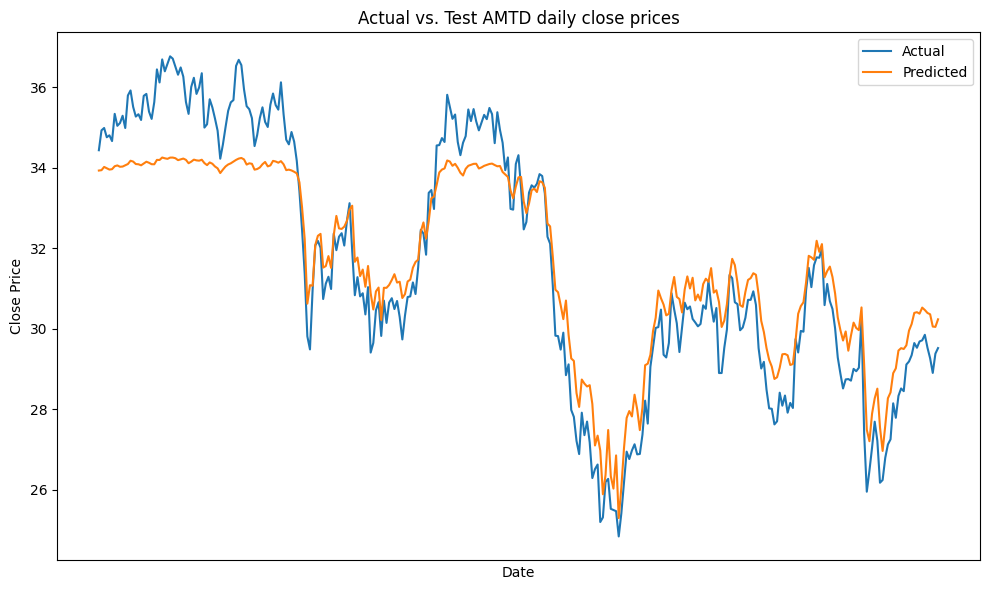

In [ ]:
amtd_model_mae = PriceClassifier("amtd")
amtd_model_mae.train(loss="mean_absolute_error")
amtd_model_mae.generate_predictions()
amtd_model_mae.plot_predictions()
amtd_model_mae.plot_train_test_val()

Epoch 1/50
80/80 [==============================] - 15s 36ms/step - loss: 148.6288 - val_loss: 774.2018
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 49.0052 - val_loss: 626.8075
Epoch 3/50
80/80 [==============================] - 1s 18ms/step - loss: 40.4883 - val_loss: 566.5811
Epoch 4/50
80/80 [==============================] - 1s 18ms/step - loss: 38.5680 - val_loss: 544.8849
Epoch 5/50
80/80 [==============================] - 2s 21ms/step - loss: 38.5863 - val_loss: 534.2097
Epoch 6/50
80/80 [==============================] - 2s 27ms/step - loss: 38.8165 - val_loss: 533.1907
Epoch 7/50
80/80 [==============================] - 2s 27ms/step - loss: 38.5321 - val_loss: 536.2631
Epoch 8/50
80/80 [==============================] - 2s 28ms/step - loss: 38.4115 - val_loss: 533.8624
Epoch 9/50
80/80 [==============================] - 2s 20ms/step - loss: 38.3437 - val_loss: 536.8389
Epoch 10/50
80/80 [==============================] - 1s 18ms/step - loss: 38.423

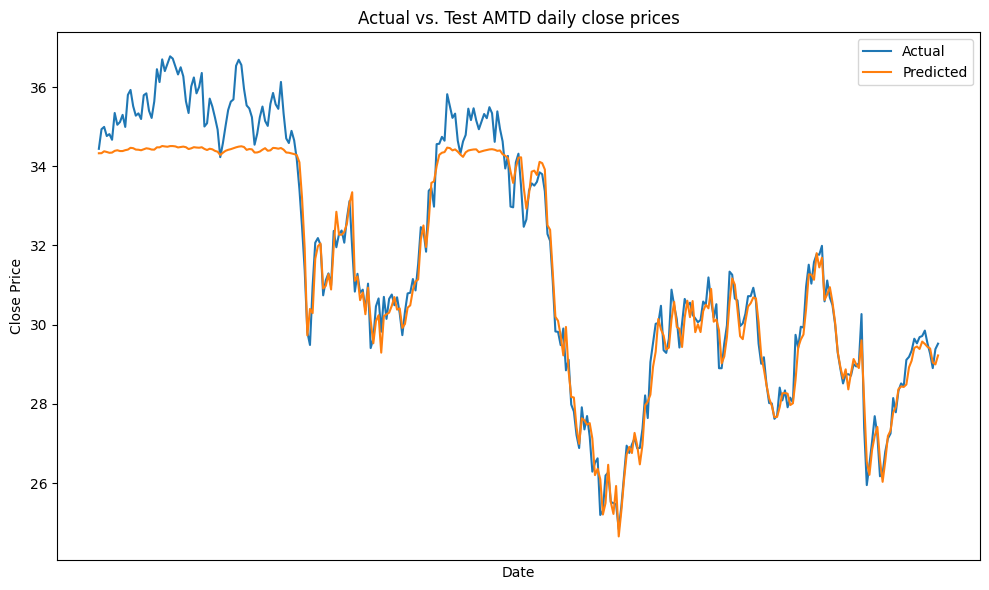

In [ ]:
amtd_model_less_dropout = PriceClassifier("amtd")
amtd_model_less_dropout.train(dropout=.1)
amtd_model_less_dropout.generate_predictions()
amtd_model_less_dropout.plot_predictions()
amtd_model_less_dropout.plot_train_test_val()

Epoch 1/50
80/80 [==============================] - 14s 60ms/step - loss: 167.7856 - val_loss: 830.4663
Epoch 2/50
80/80 [==============================] - 2s 22ms/step - loss: 57.2743 - val_loss: 666.5220
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 43.0159 - val_loss: 590.4738
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 41.4876 - val_loss: 555.1517
Epoch 5/50
80/80 [==============================] - 1s 18ms/step - loss: 40.8315 - val_loss: 544.7476
Epoch 6/50
80/80 [==============================] - 1s 17ms/step - loss: 41.1099 - val_loss: 542.5433
Epoch 7/50
80/80 [==============================] - 1s 17ms/step - loss: 40.9451 - val_loss: 540.8283
Epoch 8/50
80/80 [==============================] - 1s 17ms/step - loss: 39.9980 - val_loss: 540.8313
Epoch 9/50
80/80 [==============================] - 2s 21ms/step - loss: 40.9296 - val_loss: 536.8080
Epoch 10/50
80/80 [==============================] - 2s 26ms/step - loss: 40.419

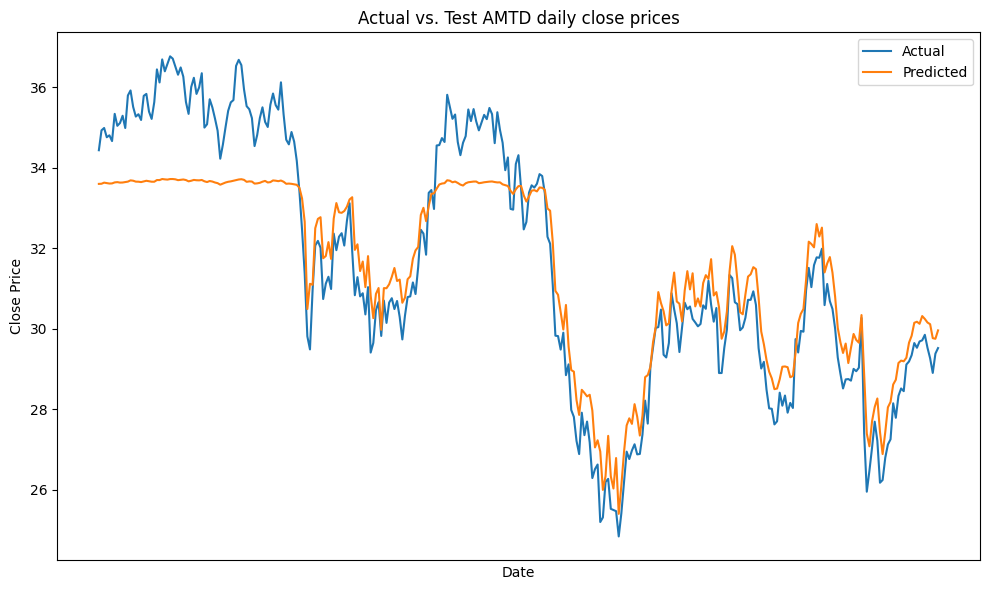

In [ ]:
amtd_model_paper_dropout = PriceClassifier("amtd")
amtd_model_paper_dropout.train(dropout=.3)
amtd_model_paper_dropout.generate_predictions()
amtd_model_paper_dropout.plot_predictions()
amtd_model_paper_dropout.plot_train_test_val()

Epoch 1/50
80/80 [==============================] - 12s 37ms/step - loss: 162.7919 - val_loss: 799.3970
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 55.4430 - val_loss: 648.6655
Epoch 3/50
80/80 [==============================] - 2s 21ms/step - loss: 45.1775 - val_loss: 581.3475
Epoch 4/50
80/80 [==============================] - 2s 27ms/step - loss: 42.5340 - val_loss: 553.1037
Epoch 5/50
80/80 [==============================] - 2s 27ms/step - loss: 41.9648 - val_loss: 545.4130
Epoch 6/50
80/80 [==============================] - 2s 27ms/step - loss: 41.7379 - val_loss: 546.0001
Epoch 7/50
80/80 [==============================] - 2s 19ms/step - loss: 42.7747 - val_loss: 545.4097
Epoch 8/50
80/80 [==============================] - 1s 17ms/step - loss: 41.1569 - val_loss: 542.3895
Epoch 9/50
80/80 [==============================] - 1s 17ms/step - loss: 42.3877 - val_loss: 539.8131
Epoch 10/50
80/80 [==============================] - 1s 17ms/step - loss: 41.585

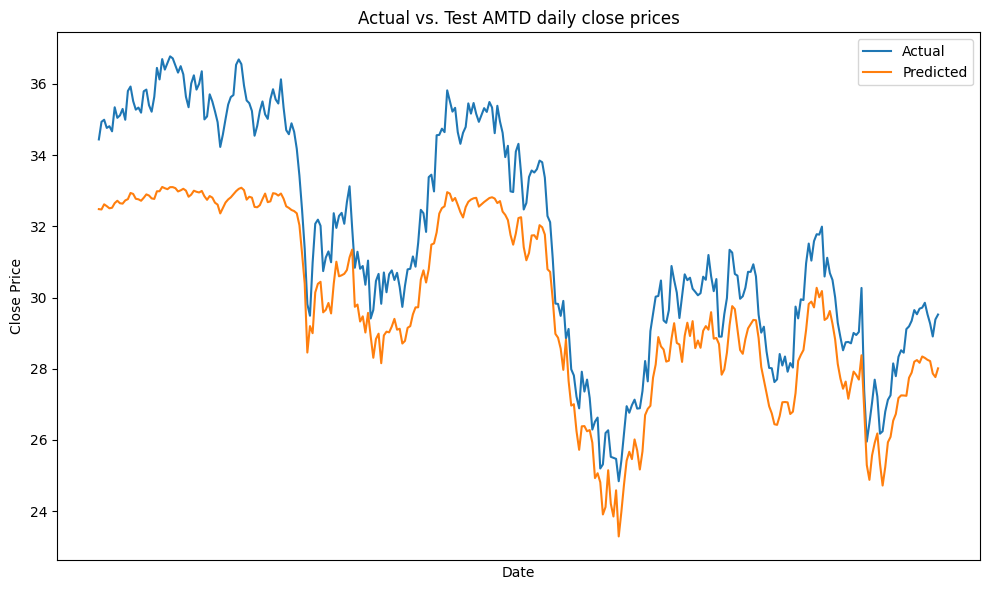

In [ ]:
amtd_model_large_dropout = PriceClassifier("amtd")
amtd_model_large_dropout.train(dropout=.4)
amtd_model_large_dropout.generate_predictions()
amtd_model_large_dropout.plot_predictions()
amtd_model_large_dropout.plot_train_test_val()

Epoch 1/50
80/80 [==============================] - 18s 54ms/step - loss: 168.3404 - val_loss: 826.9046
Epoch 2/50
80/80 [==============================] - 2s 24ms/step - loss: 56.5869 - val_loss: 665.8056
Epoch 3/50
80/80 [==============================] - 2s 28ms/step - loss: 42.2622 - val_loss: 586.4355
Epoch 4/50
80/80 [==============================] - 3s 39ms/step - loss: 39.6573 - val_loss: 556.4623
Epoch 5/50
80/80 [==============================] - 3s 40ms/step - loss: 39.4416 - val_loss: 540.9719
Epoch 6/50
80/80 [==============================] - 2s 26ms/step - loss: 39.3307 - val_loss: 537.0749
Epoch 7/50
80/80 [==============================] - 2s 26ms/step - loss: 39.0728 - val_loss: 537.6693
Epoch 8/50
80/80 [==============================] - 2s 25ms/step - loss: 39.5440 - val_loss: 539.9751
Epoch 9/50
80/80 [==============================] - 2s 24ms/step - loss: 39.1066 - val_loss: 537.3108
Epoch 10/50
80/80 [==============================] - 2s 25ms/step - loss: 38.986

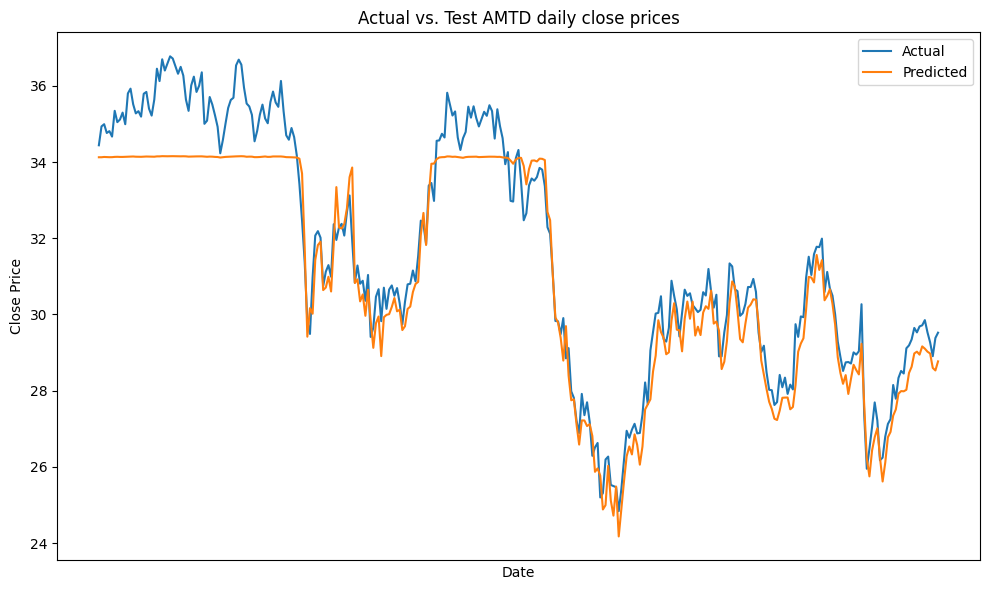

In [ ]:
amtd_6_lstm_layers = PriceClassifier("amtd")
dropout=.2
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(amtd_6_lstm_layers.X_train.shape[1], 1)))
model.add(Dropout(dropout))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(dropout))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(dropout))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(dropout))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(dropout))
model.add(LSTM(units=50))
model.add(Dropout(dropout))
model.add(Dense(units=1))
amtd_6_lstm_layers.train(model)
amtd_6_lstm_layers.generate_predictions()
amtd_6_lstm_layers.plot_predictions()

In [ ]:
amtd_model.model.evaluate(amtd_model.X_test, amtd_model.y_test)
amtd_model_less_dropout.model.evaluate(amtd_model_less_dropout.X_test, amtd_model_less_dropout.y_test)
amtd_model_paper_dropout.model.evaluate(amtd_model_paper_dropout.X_test, amtd_model_paper_dropout.y_test)
amtd_model_large_dropout.model.evaluate(amtd_model_large_dropout.X_test, amtd_model_large_dropout.y_test)

10/10 [==============================] - 0s 5ms/step - loss: 3.7414


3.741352081298828

Epoch 1/50
80/80 [==============================] - 13s 38ms/step - loss: 133.6315 - val_loss: 1015.5772
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 49.8418 - val_loss: 855.0574
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 42.5463 - val_loss: 794.8687
Epoch 4/50
80/80 [==============================] - 2s 19ms/step - loss: 41.5710 - val_loss: 779.0829
Epoch 5/50
80/80 [==============================] - 2s 27ms/step - loss: 41.5542 - val_loss: 771.0641
Epoch 6/50
80/80 [==============================] - 2s 26ms/step - loss: 41.8174 - val_loss: 773.8523
Epoch 7/50
80/80 [==============================] - 2s 27ms/step - loss: 41.7772 - val_loss: 772.9771
Epoch 8/50
80/80 [==============================] - 2s 20ms/step - loss: 41.4335 - val_loss: 778.1474
Epoch 9/50
80/80 [==============================] - 1s 17ms/step - loss: 41.6736 - val_loss: 774.1611
Epoch 10/50
80/80 [==============================] - 1s 16ms/step - loss: 33.20

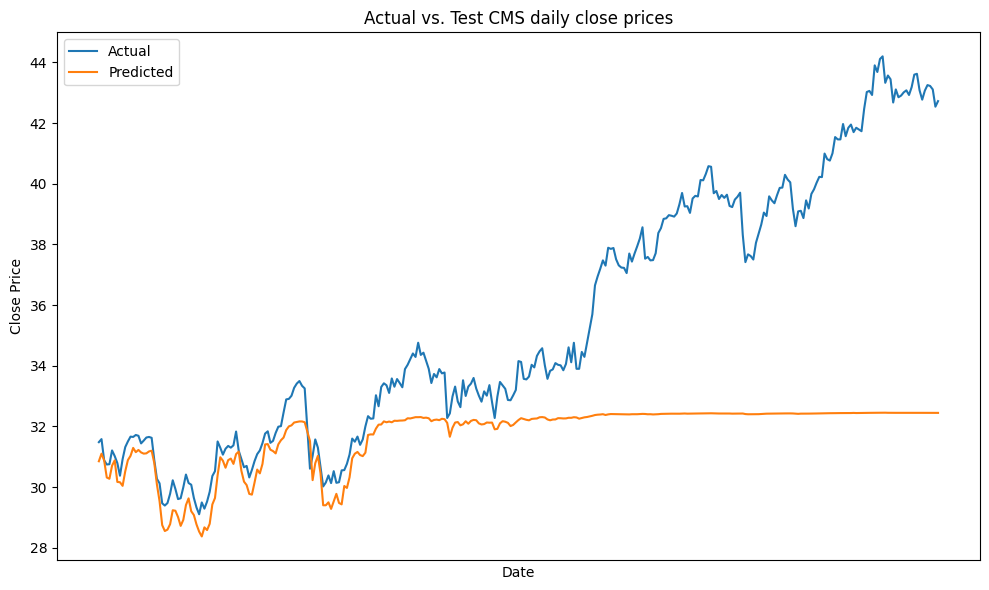

In [ ]:
cms_model = PriceClassifier("cms")
cms_model.train()
cms_model.generate_predictions()
cms_model.plot_predictions()

In [ ]:
cms_model_10_d = PriceClassifier("cms")
cms_model_10_d.train(dropout=.1)
cms_model_30_d = PriceClassifier("cms")
cms_model_30_d.train(dropout=.3)
cms_model_40_d = PriceClassifier("cms")
cms_model_40_d.train(dropout=.4)

Epoch 1/50
80/80 [==============================] - 14s 49ms/step - loss: 130.9106 - val_loss: 984.8109
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 46.6716 - val_loss: 836.2602
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 41.7265 - val_loss: 785.2178
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 41.0460 - val_loss: 772.3533
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 41.1785 - val_loss: 770.2280
Epoch 6/50
80/80 [==============================] - 1s 17ms/step - loss: 41.0941 - val_loss: 772.4131
Epoch 7/50
80/80 [==============================] - 1s 17ms/step - loss: 41.0937 - val_loss: 764.1556
Epoch 8/50
80/80 [==============================] - 2s 25ms/step - loss: 40.7844 - val_loss: 773.0676
Epoch 9/50
80/80 [==============================] - 2s 26ms/step - loss: 27.8281 - val_loss: 625.5452
Epoch 10/50
80/80 [==============================] - 2s 27ms/step - loss: 12.207

In [ ]:
cms_model_10_d.model.evaluate(cms_model_10_d.X_test, cms_model_10_d.y_test)
cms_model.model.evaluate(cms_model.X_test, cms_model.y_test)
cms_model_30_d.model.evaluate(cms_model_30_d.X_test, cms_model_30_d.y_test)
cms_model_40_d.model.evaluate(cms_model_40_d.X_test, cms_model_40_d.y_test)

10/10 [==============================] - 0s 5ms/step - loss: 29.6849


29.68490982055664

Epoch 1/50
80/80 [==============================] - 13s 37ms/step - loss: 346.3522 - val_loss: 2779.3977
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 142.8812 - val_loss: 2400.0415
Epoch 3/50
80/80 [==============================] - 2s 25ms/step - loss: 89.0332 - val_loss: 2137.8726
Epoch 4/50
80/80 [==============================] - 2s 27ms/step - loss: 62.6986 - val_loss: 1958.4777
Epoch 5/50
80/80 [==============================] - 2s 27ms/step - loss: 51.3604 - val_loss: 1842.8285
Epoch 6/50
80/80 [==============================] - 2s 24ms/step - loss: 47.1981 - val_loss: 1773.0305
Epoch 7/50
80/80 [==============================] - 1s 17ms/step - loss: 45.7514 - val_loss: 1730.7853
Epoch 8/50
80/80 [==============================] - 1s 17ms/step - loss: 45.2426 - val_loss: 1708.6636
Epoch 9/50
80/80 [==============================] - 1s 17ms/step - loss: 44.5931 - val_loss: 1698.4315
Epoch 10/50
80/80 [==============================] - 1s 17ms/step - lo

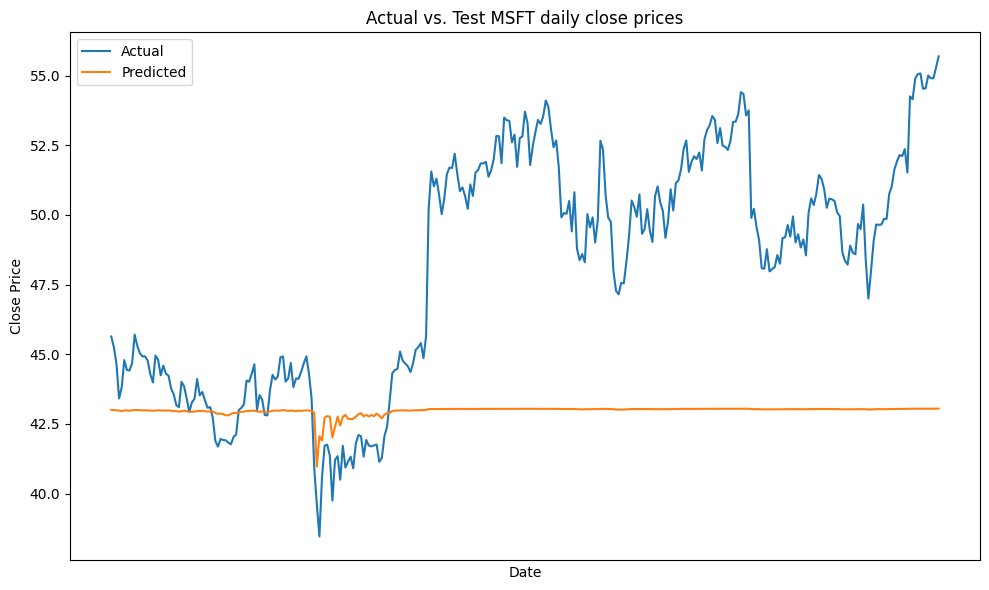

In [ ]:
msft_model = PriceClassifier("msft")
msft_model.train()
msft_model.generate_predictions()
msft_model.plot_predictions()



Epoch 1/50
80/80 [==============================] - 13s 43ms/step - loss: 725.2205 - val_loss: 2404.6567
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 491.2523 - val_loss: 2041.2255
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 416.0626 - val_loss: 1781.2411
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 373.7031 - val_loss: 1594.3481
Epoch 5/50
80/80 [==============================] - 1s 18ms/step - loss: 354.9596 - val_loss: 1459.2257
Epoch 6/50
80/80 [==============================] - 1s 17ms/step - loss: 341.7991 - val_loss: 1364.4437
Epoch 7/50
80/80 [==============================] - 2s 21ms/step - loss: 248.5326 - val_loss: 1160.0127
Epoch 8/50
80/80 [==============================] - 2s 28ms/step - loss: 187.0952 - val_loss: 956.6950
Epoch 9/50
80/80 [==============================] - 2s 27ms/step - loss: 147.6712 - val_loss: 793.5448
Epoch 10/50
80/80 [==============================] - 2s 26ms/step

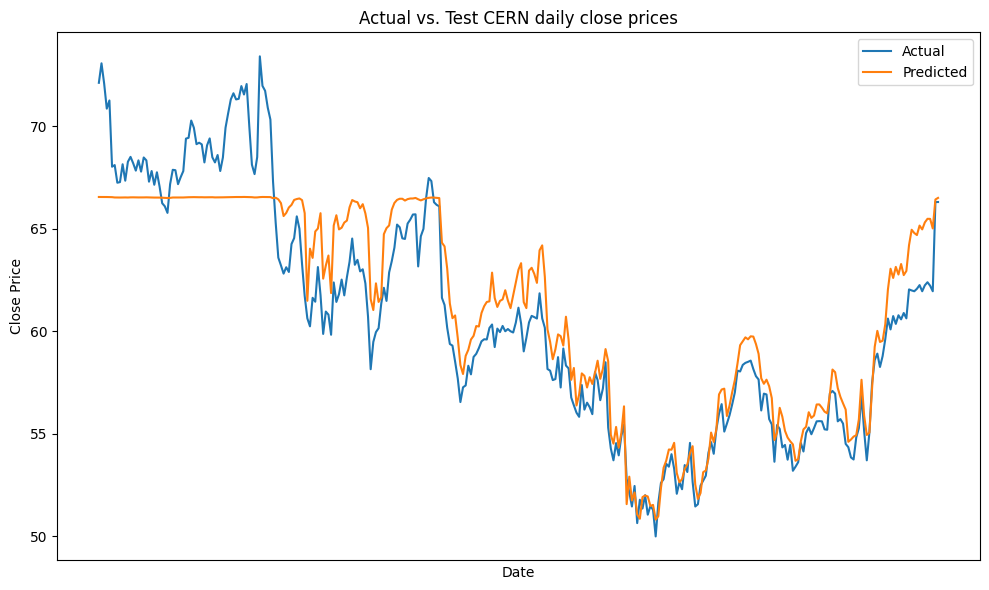

In [ ]:
cern_model = PriceClassifier("cern")
cern_model.train()
cern_model.generate_predictions()
cern_model.plot_predictions()

In [ ]:
cern_model_10_d = PriceClassifier("cern")
cern_model_10_d.train(dropout=.1)
cern_model_30_d = PriceClassifier("cern")
cern_model_30_d.train(dropout=.3)
cern_model_40_d = PriceClassifier("cern")
cern_model_40_d.train(dropout=.4)

Epoch 1/50
80/80 [==============================] - 12s 49ms/step - loss: 717.8799 - val_loss: 2340.2998
Epoch 2/50
80/80 [==============================] - 2s 27ms/step - loss: 474.4860 - val_loss: 1987.9620
Epoch 3/50
80/80 [==============================] - 2s 27ms/step - loss: 404.9163 - val_loss: 1735.3715
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 366.7384 - val_loss: 1550.6100
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 346.7539 - val_loss: 1420.2080
Epoch 6/50
80/80 [==============================] - 1s 17ms/step - loss: 337.0016 - val_loss: 1335.2583
Epoch 7/50
80/80 [==============================] - 1s 17ms/step - loss: 272.0966 - val_loss: 1180.6594
Epoch 8/50
80/80 [==============================] - 1s 17ms/step - loss: 187.3203 - val_loss: 958.2345
Epoch 9/50
80/80 [==============================] - 1s 17ms/step - loss: 145.8334 - val_loss: 790.1881
Epoch 10/50
80/80 [==============================] - 1s 18ms/step

In [ ]:
cern_model_10_d.model.evaluate(cern_model_10_d.X_test, cern_model_10_d.y_test)
cern_model.model.evaluate(cern_model.X_test, cern_model.y_test)
cern_model_30_d.model.evaluate(cern_model_30_d.X_test, cern_model_30_d.y_test)
cern_model_40_d.model.evaluate(cern_model_40_d.X_test, cern_model_40_d.y_test)

10/10 [==============================] - 0s 5ms/step - loss: 17.0315


17.03148651123047

Epoch 1/50
80/80 [==============================] - 13s 39ms/step - loss: 341.2807 - val_loss: 0.5188
Epoch 2/50
80/80 [==============================] - 2s 19ms/step - loss: 211.2156 - val_loss: 1.8276
Epoch 3/50
80/80 [==============================] - 1s 18ms/step - loss: 147.0968 - val_loss: 0.0645
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 105.4307 - val_loss: 0.1113
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 76.5276 - val_loss: 0.9011
Epoch 6/50
80/80 [==============================] - 2s 23ms/step - loss: 56.2840 - val_loss: 0.0145
Epoch 7/50
80/80 [==============================] - 2s 27ms/step - loss: 41.0946 - val_loss: 0.0751
Epoch 8/50
80/80 [==============================] - 2s 28ms/step - loss: 29.5167 - val_loss: 0.3687
Epoch 9/50
80/80 [==============================] - 2s 26ms/step - loss: 21.4165 - val_loss: 0.0302
Epoch 10/50
80/80 [==============================] - 1s 17ms/step - loss: 16.7382 - val_loss: 0

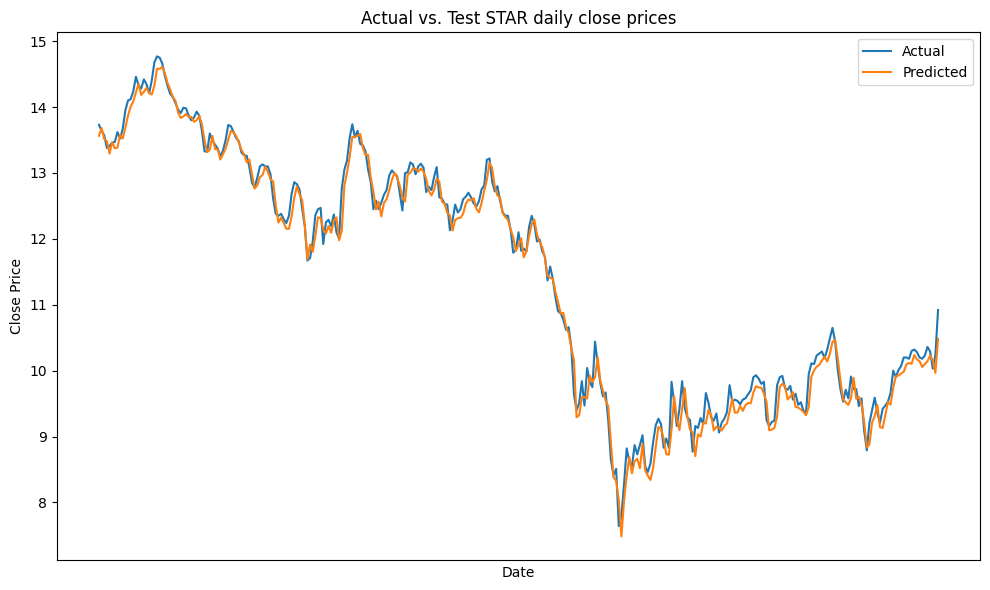

In [ ]:
['amtd', 'cern', 'fr.us.txt', 'star.us.txt', 'sons.us.txt']
star_model = PriceClassifier("star")
star_model.train()
star_model.generate_predictions()
star_model.plot_predictions()

Epoch 1/50
80/80 [==============================] - 13s 54ms/step - loss: 189.9582 - val_loss: 26.3526
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 82.2919 - val_loss: 66.3309
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 69.6959 - val_loss: 94.0751
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 67.9848 - val_loss: 106.0766
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 67.3453 - val_loss: 110.3258
Epoch 6/50
80/80 [==============================] - 1s 17ms/step - loss: 66.7542 - val_loss: 110.0762
Epoch 7/50
80/80 [==============================] - 1s 17ms/step - loss: 66.4903 - val_loss: 1.4640
Epoch 8/50
80/80 [==============================] - 1s 17ms/step - loss: 40.3970 - val_loss: 1.0226
Epoch 9/50
80/80 [==============================] - 2s 26ms/step - loss: 27.2388 - val_loss: 1.5097
Epoch 10/50
80/80 [==============================] - 2s 27ms/step - loss: 20.2307 - val_l

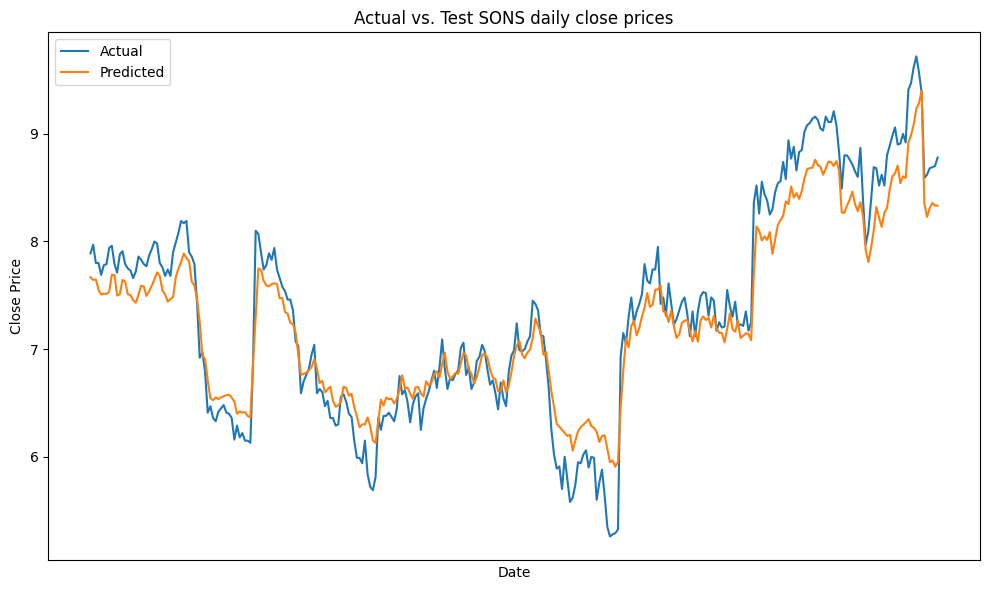

In [ ]:
sons_model = PriceClassifier("sons")
sons_model.train()
sons_model.generate_predictions()
sons_model.plot_predictions()

Epoch 1/50
80/80 [==============================] - 13s 59ms/step - loss: 304.8380 - val_loss: 256.0966
Epoch 2/50
80/80 [==============================] - 2s 24ms/step - loss: 183.4641 - val_loss: 165.1987
Epoch 3/50
80/80 [==============================] - 1s 17ms/step - loss: 141.3286 - val_loss: 102.7892
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 88.2487 - val_loss: 47.9646
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 59.7446 - val_loss: 18.2844
Epoch 6/50
80/80 [==============================] - 1s 17ms/step - loss: 39.6220 - val_loss: 5.3069
Epoch 7/50
80/80 [==============================] - 1s 17ms/step - loss: 27.8497 - val_loss: 1.9179
Epoch 8/50
80/80 [==============================] - 1s 17ms/step - loss: 18.9264 - val_loss: 1.1979
Epoch 9/50
80/80 [==============================] - 1s 17ms/step - loss: 14.0380 - val_loss: 0.2787
Epoch 10/50
80/80 [==============================] - 2s 28ms/step - loss: 10.4287 - val_

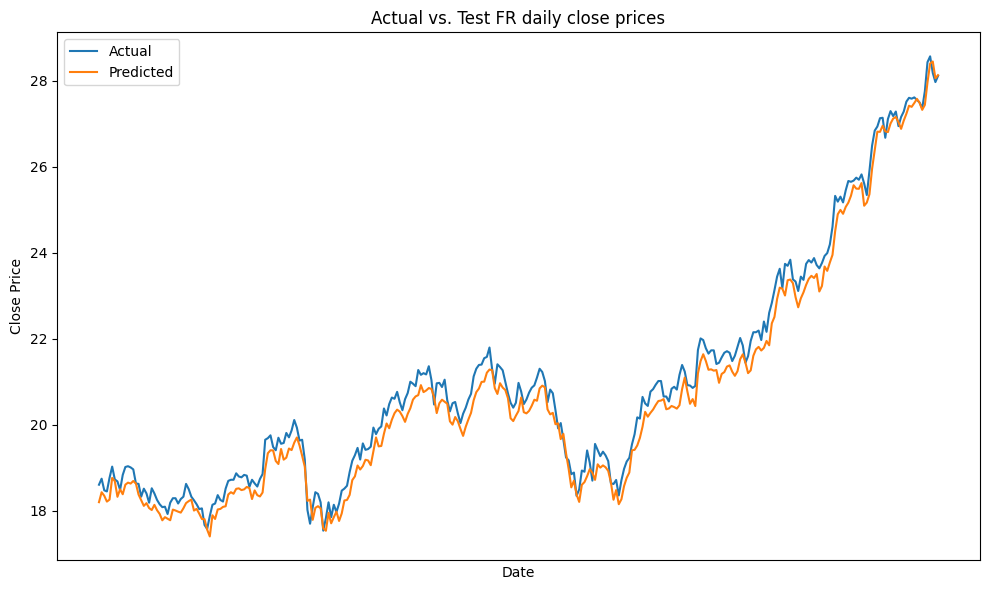

In [ ]:
fr_model = PriceClassifier("fr")
fr_model.train()
fr_model.generate_predictions()
fr_model.plot_predictions()

Epoch 1/50
80/80 [==============================] - 14s 38ms/step - loss: 104.1836 - val_loss: 352.4901
Epoch 2/50
80/80 [==============================] - 2s 19ms/step - loss: 56.3889 - val_loss: 304.8431
Epoch 3/50
80/80 [==============================] - 2s 27ms/step - loss: 55.2490 - val_loss: 298.1645
Epoch 4/50
80/80 [==============================] - 2s 27ms/step - loss: 35.1162 - val_loss: 192.1389
Epoch 5/50
80/80 [==============================] - 2s 27ms/step - loss: 18.8657 - val_loss: 122.1086
Epoch 6/50
80/80 [==============================] - 2s 21ms/step - loss: 12.0503 - val_loss: 79.8796
Epoch 7/50
80/80 [==============================] - 1s 17ms/step - loss: 7.8500 - val_loss: 55.0676
Epoch 8/50
80/80 [==============================] - 1s 17ms/step - loss: 5.8291 - val_loss: 38.7296
Epoch 9/50
80/80 [==============================] - 1s 17ms/step - loss: 4.4657 - val_loss: 29.1461
Epoch 10/50
80/80 [==============================] - 1s 17ms/step - loss: 3.7029 - val_

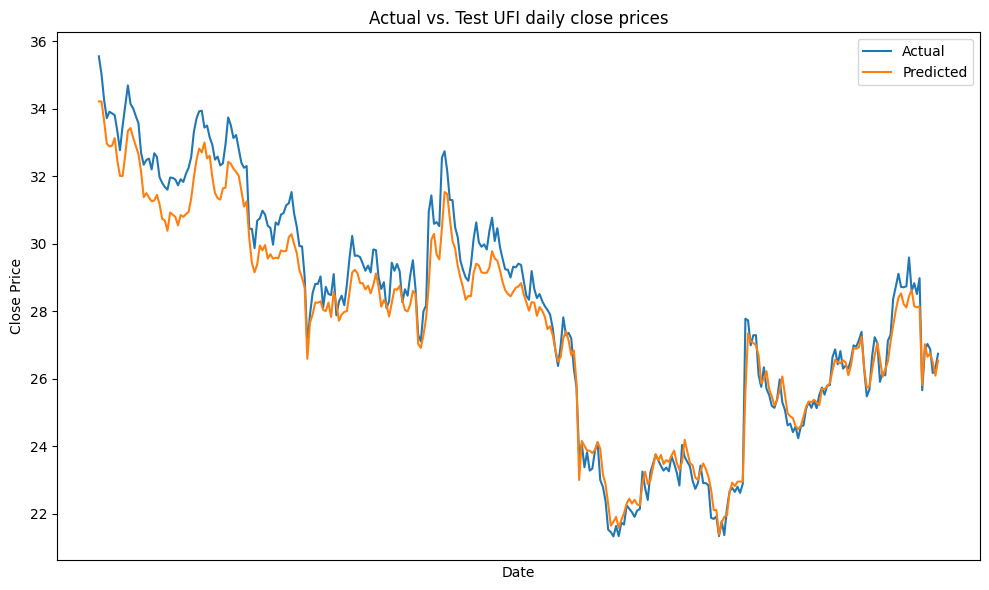

In [ ]:
ufi_model = PriceClassifier("ufi")
ufi_model.train()
ufi_model.generate_predictions()
ufi_model.plot_predictions()

Epoch 1/50
78/78 [==============================] - 13s 42ms/step - loss: 17.0867 - val_loss: 100.7859
Epoch 2/50
78/78 [==============================] - 1s 17ms/step - loss: 1.9638 - val_loss: 62.7483
Epoch 3/50
78/78 [==============================] - 1s 17ms/step - loss: 1.3502 - val_loss: 50.4795
Epoch 4/50
78/78 [==============================] - 1s 17ms/step - loss: 1.0905 - val_loss: 39.3547
Epoch 5/50
78/78 [==============================] - 1s 18ms/step - loss: 0.9591 - val_loss: 32.0183
Epoch 6/50
78/78 [==============================] - 1s 17ms/step - loss: 0.8215 - val_loss: 25.8570
Epoch 7/50
78/78 [==============================] - 2s 20ms/step - loss: 0.7378 - val_loss: 20.6078
Epoch 8/50
78/78 [==============================] - 2s 28ms/step - loss: 0.6390 - val_loss: 16.8631
Epoch 9/50
78/78 [==============================] - 2s 27ms/step - loss: 0.5566 - val_loss: 13.7100
Epoch 10/50
78/78 [==============================] - 2s 28ms/step - loss: 0.5389 - val_loss: 11.1

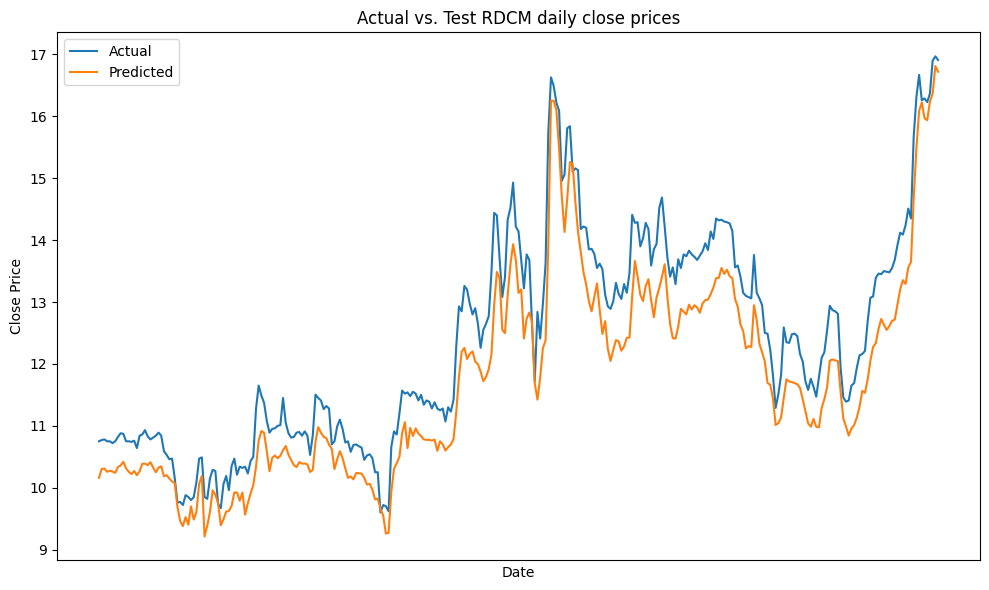

In [ ]:
rdcm_model = PriceClassifier("rdcm")
rdcm_model.train()
rdcm_model.generate_predictions()
rdcm_model.plot_predictions()

Epoch 1/50
80/80 [==============================] - 13s 62ms/step - loss: 2128.2000 - val_loss: 1130.7716
Epoch 2/50
80/80 [==============================] - 2s 25ms/step - loss: 1584.7573 - val_loss: 863.3278
Epoch 3/50
80/80 [==============================] - 1s 18ms/step - loss: 1318.3962 - val_loss: 660.6814
Epoch 4/50
80/80 [==============================] - 1s 17ms/step - loss: 1102.9662 - val_loss: 501.5784
Epoch 5/50
80/80 [==============================] - 1s 17ms/step - loss: 937.7700 - val_loss: 377.6749
Epoch 6/50
80/80 [==============================] - 1s 17ms/step - loss: 800.4688 - val_loss: 280.1516
Epoch 7/50
80/80 [==============================] - 1s 17ms/step - loss: 690.2703 - val_loss: 208.3197
Epoch 8/50
80/80 [==============================] - 1s 17ms/step - loss: 605.2311 - val_loss: 155.5258
Epoch 9/50
80/80 [==============================] - 1s 18ms/step - loss: 538.7921 - val_loss: 117.0536
Epoch 10/50
80/80 [==============================] - 2s 26ms/step -

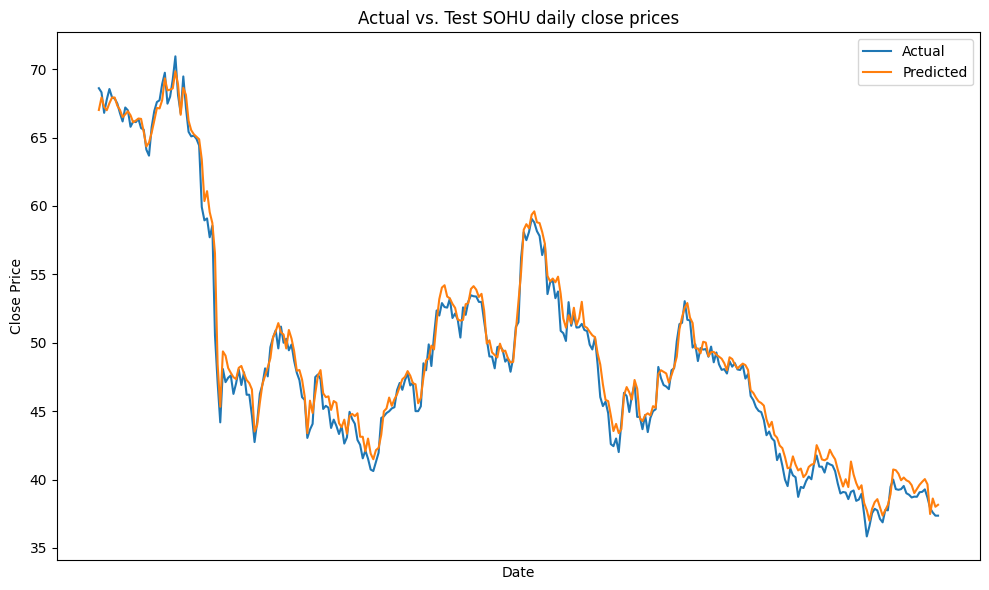

In [ ]:
sohu_model = PriceClassifier("sohu")
sohu_model.train()
sohu_model.generate_predictions()
sohu_model.plot_predictions()

Epoch 1/50
80/80 [==============================] - 12s 37ms/step - loss: 33.5744 - val_loss: 29.2139
Epoch 2/50
80/80 [==============================] - 1s 17ms/step - loss: 9.0776 - val_loss: 5.1662
Epoch 3/50
80/80 [==============================] - 1s 18ms/step - loss: 4.5473 - val_loss: 1.4628
Epoch 4/50
80/80 [==============================] - 2s 27ms/step - loss: 3.2705 - val_loss: 0.5248
Epoch 5/50
80/80 [==============================] - 2s 28ms/step - loss: 2.3120 - val_loss: 0.4519
Epoch 6/50
80/80 [==============================] - 2s 28ms/step - loss: 1.8974 - val_loss: 0.0811
Epoch 7/50
80/80 [==============================] - 2s 20ms/step - loss: 1.4350 - val_loss: 0.1407
Epoch 8/50
80/80 [==============================] - 1s 17ms/step - loss: 1.2733 - val_loss: 0.0414
Epoch 9/50
80/80 [==============================] - 1s 17ms/step - loss: 0.9235 - val_loss: 0.2101
Epoch 10/50
80/80 [==============================] - 1s 17ms/step - loss: 0.7854 - val_loss: 0.1261
Epoch 

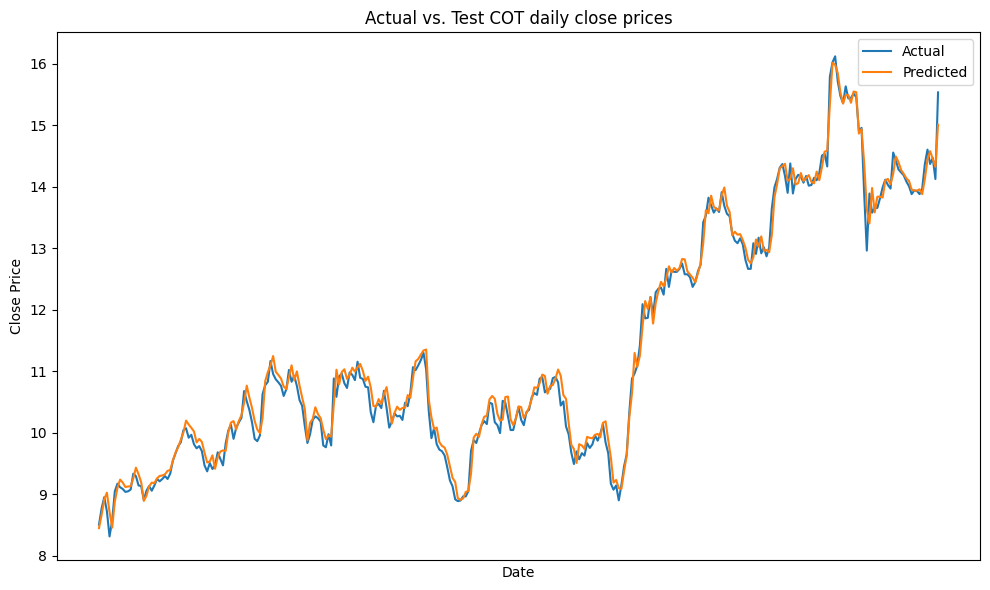

In [ ]:
cot_model = PriceClassifier("cot")
cot_model.train()
cot_model.generate_predictions()
cot_model.plot_predictions()

In [ ]:
amtd_model.plot_train_test_val()
msft_model.plot_train_test_val()
cern_model.plot_train_test_val()

# Asset Class

In [ ]:
from math import floor
from datetime import date, timedelta
from abc import ABC, abstractmethod


class Asset:

  def __init__(self, model, initalAmount = 0):

    self.model = model
    self.count = 0
    self.lastValidPrice = None
    self.count = initalAmount

  def isValid(self, actual_date, prediction_date):

    price = self.model.get_true_price_on_date(actual_date)
    predict = self.model.predict_on_date(prediction_date)

    if not price.empty and (not predict == None and not len(predict) == 0):
      return True
    else:
      return False

  def getValue(self, date):

    true_price_data = self.model.get_true_price_on_date(date)
    print(true_price_data)

    true_price_data = true_price_data["Open"]

    if not true_price_data.empty:
      self.lastValidPrice = true_price_data.iloc[0]

    return self.lastValidPrice

  def getName(self):

    return self.model.get_stock_name()

  def predict(self, date):

    prediction_data = self.model.predict_on_date(date)

    return prediction_data[0]

  def getAmount(self):

    return self.count

  def updateAmount(self, amount):

    self.count += amount


# Protfolio Base Class


In [ ]:
class MyPortfolioBase(ABC):

  def __init__(self, assets, cash, min_hold_amount, verbose):

    self.assets = assets
    self.cash = cash
    self.min_hold_amount = min_hold_amount

    self.ratesOfReturn = []

    self.verbose = verbose

  def buy(self, stockName, date):

    if self.verbose:
      print("Trying to buy one share of ", stockName)

    price = assets[stockName].getValue(date)

    if price <= self.cash:

      self.cash -= price
      assets[stockName].updateAmount(1)

      if self.verbose:
        print("Buy Succesful")

      return True

    else:

      if self.verbose:
        print("Buy Un-Succesful")

      return False

  def sell(self, stockName, date):

    if self.verbose:
      print("Trying to sell one share of ", stockName)

    price = assets[stockName].getValue(date)
    amount = assets[stockName].getAmount()

    if amount > self.min_hold_amount and amount > 0:

      self.cash += price
      assets[stockName].updateAmount(-1)
      return True

      if self.verbose:
        print("Sell Succesful")

    else:

      if self.verbose:
        print("Sell Un-Succesful")
      return False

  def isValid(self, actual_date, prediction_date):
    for key, value in self.assets.items():

      if not value.isValid(actual_date, prediction_date):

        if self.verbose:
          print("Date not valid for ", key)

        return False

    return True

  def addReturnDataPoint(self, init_val, date):

    rate_of_return = (self.getEval(date) - init_val)/init_val

    self.ratesOfReturn.append(rate_of_return)

  def getEval(self, date):

    evaluation = self.cash

    for key, value in self.assets.items():
      print(value.getValue(date))
      evaluation += (value.getValue(date) * value.getAmount())

    return evaluation


  def printSummary(self, date):

    evaluation = self.cash

    print()
    print("Cash: ", self.cash)

    for key, value in self.assets.items():

      print(value.getName(), ": ", value.getAmount(), " @ ", value.getValue(date))
      evaluation += (value.getValue(date) * value.getAmount())


    print("Total evaluation: ", evaluation)
    print()

  @abstractmethod
  def trade(self, date):
    pass

# Implementation of Algorithm One Protfolio

1. This algorithm sells as much overvalued stock as it can before hitting the min limit

2. It then buys as much undervalued stock as it can with it's cash

In [ ]:
class AlgorithmOneProtfolio(MyPortfolioBase):

  def __init__(self, assets, cash, min_hold_amount, verbose):

    super().__init__(assets, cash, min_hold_amount, verbose)


  def trade(self, actual_date, prediction_date):

    priceMap = {}
    priceDiffMap = {}

    for key, value in self.assets.items():


      if self.verbose:
        print("Checking ", key, "...")

      priceDiffMap[key] = value.predict(prediction_date) - value.getValue(actual_date)
      priceMap[key] = value.getValue(actual_date)

      if self.verbose:
        print("predicted: ", value.predict(prediction_date), " current: ", value.getValue(actual_date))


    lowestValuedStock = None
    lowDiff = 0
    highestValuedStock = None
    highDiff = 0

    for key, value in priceDiffMap.items():

      if value < 0 and value < lowDiff:

        lowestValuedStock = key
        lowDiff = value

      elif value > 0 and value > highDiff:

        highestValuedStock = key
        highDiff = value


    if lowestValuedStock is not None:

      while(self.sell(lowestValuedStock, actual_date)):
        pass


    if highestValuedStock is not None:

      while(self.buy(highestValuedStock, actual_date)):
        pass


# Top Level Time Series Class

In [ ]:
class TimeSeriesSimulation:

  def __init__(self, step_size, start_date, end_date, portfolio, look_forward_step):

    self.step_size = step_size
    self.start_date = start_date
    self.end_date = end_date
    self.portfolio = portfolio
    self.look_forward_step = datetime.timedelta(days=look_forward_step)
    self.single_day = datetime.timedelta(days=1)

    self.init_eval = portfolio.getEval(start_date.strftime("%Y-%m-%d"))
    self.return_rate = None
    self.return_std_dev = None
    self.avg_return = None


  def run(self):
    current_date = self.start_date

    counter = 1

    while (current_date <= self.end_date):

      print("### START TIME STEP ", counter, " ###")
      print("Date is ", current_date)

      while(not self.portfolio.isValid(current_date.strftime("%Y-%m-%d"), (current_date + self.look_forward_step).strftime("%Y-%m-%d"))):
        if current_date >= self.end_date:
          self.finish()
          return

        current_date += self.single_day

      self.portfolio.trade(current_date.strftime("%Y-%m-%d"), (current_date + self.look_forward_step).strftime("%Y-%m-%d"))

      self.portfolio.addReturnDataPoint(self.init_eval, current_date.strftime("%Y-%m-%d"))

      self.portfolio.printSummary(current_date.strftime("%Y-%m-%d"))

      current_date += datetime.timedelta(days = self.step_size)
      print("### END TIME STEP ", counter, " ###")
      print()

      counter += 1

    self.finish()

  def finish(self):

    final_eval = self.portfolio.getEval(self.end_date.strftime("%Y-%m-%d"))
    self.return_rate = (final_eval - self.init_eval)/self.init_eval

    rates = np.array(self.portfolio.ratesOfReturn)
    print(rates)
    self.return_std_dev = np.std(rates)
    self.avg_return = np.mean(rates)

    print()
    print("Final Summary")
    self.portfolio.printSummary(self.end_date)

    print("Inital Value was ", self.init_eval)
    print("Rate of return: ", self.return_rate)
    print("Std Dev: ", self.return_std_dev)


  def getSharpStats(self):

    return self.avg_return, self.return_std_dev


# Test Run of a Simulation

In [ ]:
assets = {"amtd": Asset(amtd_model, initalAmount=25), "cern": Asset(cern_model, initalAmount=25), "star": Asset(star_model, initalAmount=25), "sons": Asset(sons_model, initalAmount=25), "fr": Asset(fr_model, initalAmount=25), "ufi": Asset(ufi_model, initalAmount=25), "rdcm": Asset(rdcm_model, initalAmount=25) , "sohu": Asset(sohu_model, initalAmount=25)  }

algo_one_portfolio = AlgorithmOneProtfolio(assets, 2500, 15, verbose=True)

timeSeries = TimeSeriesSimulation(step_size = 20, start_date = datetime.date.fromisoformat('2014-04-30') , end_date = datetime.date.fromisoformat('2016-04-30'), portfolio = algo_one_portfolio, look_forward_step=20)

timeSeries.run()

Streaming output truncated to the last 5000 lines.
2655  42.52  43.5  42.05  262400        0
       Open  High    Low  Volume  OpenInt
2655  42.52  43.5  42.05  262400        0
1/1 [==============================] - 0s 29ms/step
       Open  High    Low  Volume  OpenInt
2655  42.52  43.5  42.05  262400        0
predicted:  [44.989563]  current:  42.52
Trying to sell one share of  amtd
        Open   High     Low   Volume  OpenInt
2655  32.234  32.76  32.187  2118872        0
Trying to sell one share of  amtd
        Open   High     Low   Volume  OpenInt
2655  32.234  32.76  32.187  2118872        0
Trying to sell one share of  amtd
        Open   High     Low   Volume  OpenInt
2655  32.234  32.76  32.187  2118872        0
Trying to sell one share of  amtd
        Open   High     Low   Volume  OpenInt
2655  32.234  32.76  32.187  2118872        0
Trying to sell one share of  amtd
        Open   High     Low   Volume  OpenInt
2655  32.234  32.76  32.187  2118872        0
Trying to sell o

# Evalulations

## Sharpe Ratio

In [ ]:
## Risk Free Rate is the current going rate for 2 Year US T Bills
risk_free = .04201


def sharpeRatio(return_rate, risk_free, std_dev):
  return (return_rate - risk_free) / std_dev


return_rate, std = timeSeries.getSharpStats()

my_port_sharpe = sharpeRatio(return_rate, risk_free, std)
print(my_port_sharpe)

2.1032819276045154


## Sharpe Ratios for Mainstream Portfolios

In [ ]:
ray_dalio_sharpe = 1.84
warren_sharpe = .98

Graph

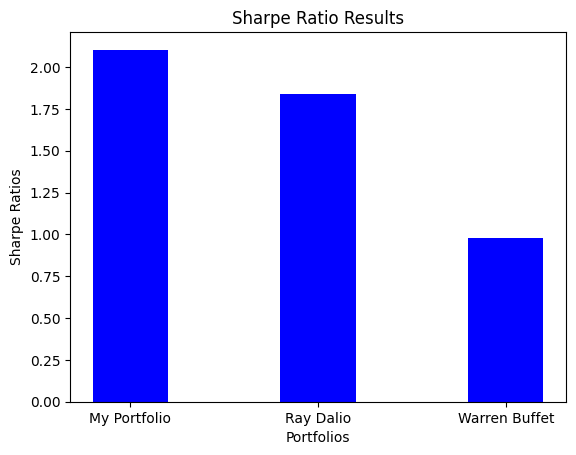

In [ ]:
y = [my_port_sharpe, ray_dalio_sharpe, warren_sharpe]
x = ["My Portfolio", "Ray Dalio", "Warren Buffet"]

# creating the bar plot
plt.bar(x, y, color ='blue',
        width = 0.4)

plt.xlabel("Portfolios")
plt.ylabel("Sharpe Ratios")
plt.title("Sharpe Ratio Results")
plt.show()

## Return Rates

In [ ]:
ray_dalio_return = 5.91
warren_return = 22.8

Graph

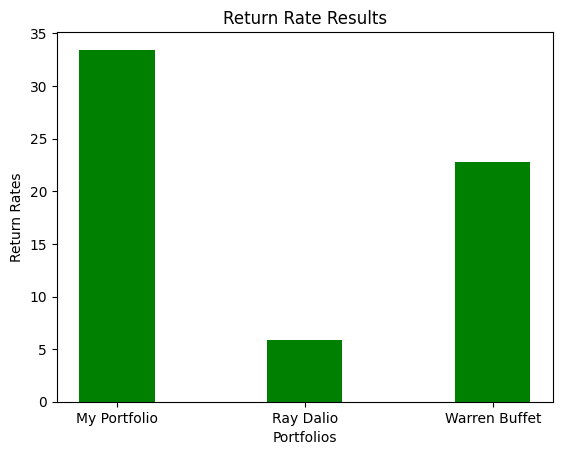

In [ ]:
y = [return_rate * 100, ray_dalio_return, warren_return]
x = ["My Portfolio", "Ray Dalio", "Warren Buffet"]

# creating the bar plot
plt.bar(x, y, color ='green',
        width = 0.4)

plt.xlabel("Portfolios")
plt.ylabel("Return Rates")
plt.title("Return Rate Results")
plt.show()